In [1]:
# license: GPL v3
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# characters of each type to sample
teamSizes = {
    "townsfolk" : 13,
    "outsider" : 4,
    "minion" : 4,
    "demon" : 4,
}

In [3]:
# a version of Standard "Amy" order
def SAO(_s):
    s = _s.lower()
    if s.startswith("you start"):
        return 1
    if s.startswith("each night*"):
        return 3
    if s.startswith("each night"):
        return 2
    if s.startswith("each day"):
        return 4
    if s.startswith("once per game, at night*"):
        return 6
    if s.startswith("once per game, at night"):
        return 5
    if s.startswith("once per game, during the day"):
        return 7
    if s.startswith("once per game"):
        return 8
    if s.startswith("on your 1st day"):
        return 10
    if s.startswith("on your 1st night"):
        return 9
    if s.startswith("if you"):
        return 11
    if s.startswith("if"):
        return 12
    if s.startswith("you"):
        return 13
    return 14

In [4]:
# record the team and SAO class of each role, etc
teams = {}
roleSAOs = {}
roleTeams = {}

roles = []
rolesInv = {}

for team in teamSizes.keys():
    teams[team] = []
    
with open("roles.json") as j:
    jsonRoles = json.load(j)
    jsonRoles = sorted(jsonRoles, key=lambda x: SAO(x["ability"]))
    jsonRoles = sorted(jsonRoles, key=lambda x: x["team"], reverse=True)
    for role in jsonRoles:
        if role["team"] not in teams:
            continue
        teams[role["team"]].append(role["id"])
        roleSAOs[role["id"]] = SAO(role["ability"])
        roles.append(role["id"])
        rolesInv[role["id"]] = len(roles)-1
        roleTeams[role["id"]] = role["team"]

In [5]:
# set role adjacency matrix
# set SAO distribution (for townsfolk)
roleAdjacency = np.zeros((len(roles), len(roles)))
amyDist = {}

for i in sorted(roleSAOs.values()):
    amyDist[i] = 0

scripts = glob.glob(os.path.join("./","data_scripts/")+"*.json")
for script in scripts:
    with open(script) as j:
        jsonScript = json.load(j)
        scriptRoles = []
        for role in jsonScript:
            if role["id"] not in roles:
                continue
            if roleTeams[role["id"]] not in teams:
                continue
            scriptRoles.append(role["id"])
            assert(role["id"] in roles)
            if role["id"] in teams["townsfolk"]:
                amyDist[roleSAOs[role["id"]]] += 1
        for role1 in scriptRoles:
            for role2 in scriptRoles:
                roleAdjacency[rolesInv[role1],rolesInv[role2]] += 1

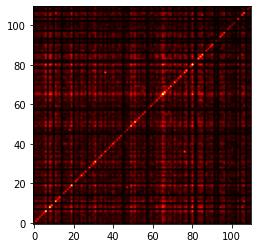

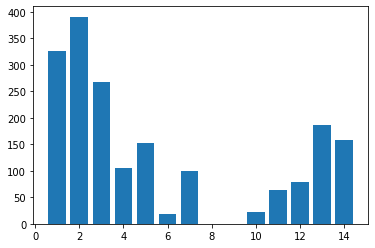

In [9]:
# heatmap of adjacency matrix
plt.clf()
plt.imshow(roleAdjacency, cmap='hot')
plt.gca().invert_yaxis()
plt.show()

# SAO distribution
plt.clf()
plt.bar(amyDist.keys(), amyDist.values())
plt.show()

In [7]:
def WeightedSampleFromDict(d):
    k = np.array(list(d.keys()))
    p = np.array(list(d.values())) / np.sum(list(d.values()))
    return np.random.choice(k, 1, p=p)[0]

def SAOsort(roleList):
    roleList = sorted(roleList)
    roleList = sorted(roleList, key=lambda x: roleSAOs[x])
    roleList = sorted(roleList, key=lambda x: roleTeams[x], reverse=True)
    return roleList
    
class Script:
    def __init__(self, teams, teamSizes, roleAdjacency, amyDist, seed=0, steps=1000):        
        self.teams = teams
        self.teamSizes = teamSizes
        self.roleAdjacency = roleAdjacency
        self.amyDist = amyDist
        self.alpha = 0 # pref attach base weight
        self.beta = 1 # pref attach power
        
        self.script = {}
        for team,n in self.teamSizes.items():
            self.script[team] = np.random.choice(self.teams[team], n, replace=False)

        self.nSteps = 0
        self.seed = seed
        np.random.seed(seed)
        self.Steps(steps)
            
    def ListRoles(self):
        return [role for team in self.script for role in self.script[team]]
    
    def Step(self):
        # Gibbs sampler step
        self.nSteps += 1
        
        # choose which role to resample
        team = WeightedSampleFromDict(self.teamSizes)
        i = np.random.randint(1,len(self.script[team]))
        self.script[team][i] = ""
        
        # set role weights according to (sum of) adjacency to current roles
        sao = WeightedSampleFromDict(self.amyDist) # and filter by SAO dist if townsfolk
        scriptRoles = self.ListRoles()
        roleWeights = {}
        for role1 in scriptRoles:
            if not role1:
                continue
            for role2 in roles:
                if roleTeams[role2] != team:
                    continue
                if team == "townsfolk" and roleSAOs[role2] != sao:
                    continue
                if role2 in scriptRoles:
                    continue
                if role2 not in roleWeights:
                    roleWeights[role2] = self.alpha
                roleWeights[role2] += self.roleAdjacency[rolesInv[role1],rolesInv[role2]] ** self.beta
        
        # resample
        if np.sum(list(roleWeights.values())) > 0:
            newRole = WeightedSampleFromDict(roleWeights)
        else:
            newRole = np.random.choice(teams[team])
        self.script[team][i] = newRole        
        
    def Steps(self, n):
        for i in range(n):
            self.Step()
        
        
    def __repr__(self):
        s = "script: " + self.ID()
        s += "\n***********\n"
        for _,teamRoles in self.script.items():
            teamRoles = SAOsort(teamRoles)
            s += ' \n'.join(teamRoles)
            s += '\n***********\n'
        return s
    
    def ID(self):
        return "%d_%d" % (self.nSteps, self.seed)
    
    def Save(self):
        # save in json format compatible with clocktower.online
        j = []
        roles = SAOsort(self.ListRoles())
        for role in roles:
            j.append({"id":role})
        with open("script_"+self.ID()+'.json', 'w') as f:
            json.dump(j, f)
               

In [8]:
# generate a script
seed = np.random.randint(10**3,10**4-1)
steps = np.random.randint(10**3,10**4-1)

script = Script(teams, teamSizes, roleAdjacency, amyDist, seed=seed, steps=steps)
print(script)
#script.Save()

script: 5324_9983
***********
chef 
clockmaker 
librarian 
balloonist 
chambermaid 
dreamer 
sailor 
flowergirl 
innkeeper 
savant 
engineer 
alchemist 
magician
***********
goon 
politician 
recluse 
heretic
***********
cerenovus 
assassin 
mastermind 
marionette
***********
alhadikhia 
vigormortis 
vortox 
zombuul
***********

